In [1]:
from glob import glob 

In [2]:
files = glob("../data/lc/*.dat")
files.sort()
files

['../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_gp_10px_bjd-flux-err-am.dat',
 '../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_ip_10px_bjd-flux-err-am.dat',
 '../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_rp_10px_bjd-flux-err-am.dat',
 '../data/lc/TIC470381900-01_20201223_LCO-Hal-M3_zs_10px_bjd-flux-err-am.dat']

In [3]:
import pandas as pd

lcs = {}
for f in files:
    b = f.split("_")[-3]
    lc = pd.read_csv(f, delimiter="\t")
    lcs[b] = lc
    print(f"{b}: {lc.shape}")

gp: (35, 4)
ip: (89, 4)
rp: (41, 4)
zs: (131, 4)


In [4]:
lcs['gp'].head()

,#BJD_TDB,rel_flux_T1_n,rel_flux_err_T1_n,AIRMASS
0,2.459207e+06,0.999639,0.005508,1.690677
1,2.459207e+06,0.998265,0.003878,1.628061
2,2.459207e+06,0.999853,0.003655,1.599124
3,2.459207e+06,1.000971,0.003558,1.571578
4,2.459207e+06,0.999497,0.003525,1.545440


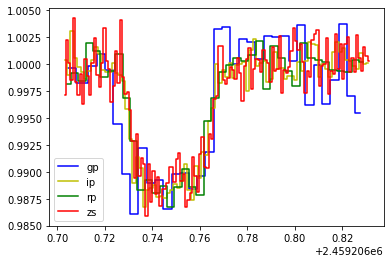

In [5]:
import matplotlib.pyplot as pl

colors = {"gp": "b",
          "rp": "g", 
          "ip": "y", 
          "zs": "r"
         }

for b in lcs:
    t = lcs[b]['#BJD_TDB']
    f = lcs[b]['rel_flux_T1_n']
#     pl.plot(t, f, c=colors[b], marker='.', ls='', label=b)
    pl.plot(t, f, c=colors[b], drawstyle='steps-mid', label=b)
pl.legend()

## LPF

In [6]:
import math as mt
import pandas as pd
import seaborn as sb
import warnings
from numpy import log, pi, inf, atleast_2d, zeros, sqrt, isfinite, clip, where, random, array, ndarray, median, squeeze, seterr, asarray
from matplotlib.pyplot import subplots, setp

with warnings.catch_warnings():
    cp = sb.color_palette()

from pathlib import Path
from IPython.display import display, HTML
from numba import njit, prange
from astropy.io import fits as pf
from emcee import EnsembleSampler
from tqdm.auto import tqdm
from corner import corner

# from ldtk import LDPSetCreator
from pytransit import QuadraticModel
from pytransit.utils.de import DiffEvol
from pytransit.orbits.orbits_py import as_from_rhop,  i_from_ba
from pytransit.param.parameter import (ParameterSet, GParameter, PParameter, LParameter,
                                       NormalPrior as NP, 
                                       UniformPrior as UP)
seterr('ignore')
random.seed(0)

In [7]:
@njit(parallel=True, cache=False, fastmath=True)
def lnlike_normal_v(o, m, e):
    m = atleast_2d(m)
    npv = m.shape[0]
    npt = o.size
    lnl = zeros(npv)
    for i in prange(npv):
        for j in range(npt):
            lnl[i] += -log(e[i]) - 0.5*log(2*pi) - 0.5*((o[j]-m[i,j])/e[i])**2
    return lnl

@njit
def change_depth(relative_depth, flux, lcids, pbids):
    npt = lcids.size
    npop = relative_depth.shape[0]
    flux = atleast_2d(flux)
    flux2 = zeros_like(flux)
    for ipv in range(npop):
        for ipt in range(npt):
            flux2[ipv, ipt] = (flux[ipv, ipt] - 1.) * relative_depth[ipv, pbids[lcids[ipt]]] + 1.
    return flux2

In [8]:
class LPFunction:
    def __init__(self, name: str, times: ndarray = None, fluxes: ndarray = None,
                 radius_ratio: str = 'achromatic', with_contamination=False
                ):
        assert radius_ratio in ('chromatic', 'achromatic')
        
        self.tm = QuadraticModel(klims=(0.05, 0.25), nk=512, nz=512)

        # LPF name
        # --------
        self.name = name
        
        # Declare high-level objects
        # --------------------------
        self.ps = None          # Parametrisation
        self.de = None          # Differential evolution optimiser
        self.sampler = None     # MCMC sampler

        # Initialize data
        # ---------------
        self.times = asarray(times)
        self.fluxes = asarray(fluxes)
        self.tm.set_data(self.times)

        # Define the parametrisation
        # --------------------------
        self.ps = ParameterSet([
            GParameter('tc',  'zero_epoch',       'd',      NP(0.0,  0.1), (-inf, inf)),
            GParameter('pr',  'period',           'd',      NP(1.0, 1e-5), (0,    inf)),
            GParameter('rho', 'stellar_density',  'g/cm^3', UP(0.1, 25.0), (0,    inf)),
            GParameter('b',   'impact_parameter', 'R_s',    UP(0.0,  1.0), (0,      1)),
            GParameter('k2', 'area_ratio', 'A_s', UP(0.05**2, 0.25**2), (0.05**2, 0.25**2)),
            GParameter('q1', 'q1_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('q2', 'q2_coefficient', '', UP(0, 1), bounds=(0, 1)),
            GParameter('loge', 'log10_error', '', UP(-4, 0), bounds=(-4, 0))])
        self.ps.freeze()
        
        self.chromatic_transit = radius_ratio == 'chromatic'
        self.radius_ratio = radius_ratio
        self.with_contamination = with_contamination

    def _init_p_planet(self):
        """Planet parameter initialisation.
        """
        if self.radius_ratio == 'achromatic':
            pk2 = [PParameter('k2', 'area_ratio', 'A_s', UP(0.005**2, 0.25**2), (0.005**2, 0.25**2))]
            self.ps.add_passband_block('k2', 1, 1, pk2)
            self._pid_k2 = repeat(self.ps.blocks[-1].start, self.npb)
        else:
            pk2 = [PParameter(f'k2_{pb}', f'area_ratio {pb}', 'A_s', UP(0.005**2, 0.25**2), (0.005**2, 0.25**2)) for pb in self.passbands]
            self.ps.add_passband_block('k2', 1, self.npb, pk2)
            self._pid_k2 = arange(self.npb) + self.ps.blocks[-1].start
        self._start_k2 = self.ps.blocks[-1].start
        self._sl_k2 = self.ps.blocks[-1].slice

        if self.with_contamination:
            pcn = [PParameter('cnt_ref', 'Reference contamination', '', UP(0., 1.), (0., 1.))]
            pcn.extend([PParameter(f'cnt_{pb}', 'contamination', '', UP(-1., 1.), (-1., 1.)) for pb in self.passbands[1:]])
            self.ps.add_passband_block('contamination', 1, self.npb, pcn)
            self._pid_cn = arange(self.ps.blocks[-1].start, self.ps.blocks[-1].stop)
            self._sl_cn = self.ps.blocks[-1].slice
            
    def create_pv_population(self, npop=50):
        return self.ps.sample_from_prior(npop)
        
    def baseline(self, pv):
        """Multiplicative baseline"""
        return 1.

    def transit_model(self, pv, copy=True):
        pv = atleast_2d(pv)
        
        # Map from sampling parametrisation to the transit model parametrisation
        # ----------------------------------------------------------------------

        if self.chromatic_transit:
            mean_ar = pv[:, self._sl_k2].mean(1)
            pvv = zeros((pv.shape[0], pv.shape[1]-self.npb+1))
            pvv[:, :4] = pv[:, :4]
            pvv[:, 4] = mean_ar
            pvv[:, 5:] = pv[:, 4+self.npb:]

            pvp = map_pv(pvv)
            ldc = map_ldc(pvv[:, 5:5 + 2 * self.npb])
            flux = self.tm.evaluate_pv(pvp, ldc, copy)
            rel_ar = pv[:, self._sl_k2] / mean_ar[:,newaxis]
            flux = change_depth(rel_ar, flux, self.lcids, self.pbids)
        else:
            k  = sqrt(pv[:, 4])                # Radius ratio
            tc = pv[:, 0]                      # Zero epoch
            p  = pv[:, 1]                      # Orbital period
            sa = as_from_rhop(pv[:, 2], p)     # Scaled semi-major axis
            i  = i_from_ba(pv[:, 3], sa)       # Orbital inclination

            # Map the limb darkening
            # ----------------------
            ldc = zeros((pv.shape[0],2))
            a, b = sqrt(pv[:,5]), 2.*pv[:,6]
            ldc[:,0] = a * b
            ldc[:,1] = a * (1. - b)
            flux = squeeze(self.tm.evaluate(k, ldc, tc, p, sa, i))
                
        if self.with_contamination:
            p = pv[:, self._sl_cn]
            pv_cnt = zeros((pv.shape[0], self.npb))
            pv_cnt[:,0] = p[:,0]
            pv_cnt[:,1:] = p[:,1:] + p[:,0][:, newaxis]
            bad = any(pv_cnt < 0.0, 1)
            flux = contaminate(flux, pv_cnt, self.lcids, self.pbids)
            flux[bad,0] = inf
            
        return flux

    def add_t14_prior(self, mean: float, std: float) -> None:
        """Add a normal prior on the transit duration.
        Parameters
        ----------
        mean
        std
        Returns
        -------
        """
        def T14(pv):
            pv = atleast_2d(pv)
            a = as_from_rhop(pv[:,2], pv[:,1])
            t14 = duration_eccentric(pv[:,1], sqrt(pv[:,4]), a, arccos(pv[:,3] / a), 0, 0, 1)
            return norm.logpdf(t14, mean, std)
        self.lnpriors.append(T14)
        
#     def add_ldtk_prior(self, teff: tuple, logg: tuple, z: tuple,
#                        uncertainty_multiplier: float = 3,
#                        pbs: tuple = ('g', 'r', 'i', 'z')) -> None:
#         """Add a LDTk-based prior on the limb darkening.
#         Parameters
#         ----------
#         teff
#         logg
#         z
#         uncertainty_multiplier
#         pbs
#         Returns
#         -------
#         """
#         fs = {n: f for n, f in zip('g r i z'.split(), (sdss_g, sdss_r, sdss_i, sdss_z))}
#         filters = [fs[k] for k in pbs]
#         self.ldsc = LDPSetCreator(teff, logg, z, filters)
#         self.ldps = self.ldsc.create_profiles(1000)
#         self.ldps.resample_linear_z()
#         self.ldps.set_uncertainty_multiplier(uncertainty_multiplier)
#         def ldprior(pv):
#             pv = atleast_2d(pv)
#             lnl = zeros(pv.shape[0])
#             for i in range(pv.shape[0]):
#                 lnl[i] = self.ldps.lnlike_tq(pv[i, self._sl_ld])
#             return lnl
#         self.lnpriors.append(ldprior)
        
    def flux_model(self, pv):
        return self.transit_model(pv) * self.baseline(pv)

    def residuals(self, pv):
        return self.fluxes - self.flux_model(pv)

    def set_prior(self, pid: int, prior) -> None:
            self.ps[pid].prior = prior

    def lnprior(self, pv):
        return self.ps.lnprior(pv)

    def lnlikelihood(self, pv):
        flux_m = self.flux_model(pv)
        wn = 10**(atleast_2d(pv)[:, 7])
        return lnlike_normal_v(self.fluxes, flux_m, wn)

    def lnposterior(self, pv):
        lnp = self.lnprior(pv) + self.lnlikelihood(pv)
        return where(isfinite(lnp), lnp, -inf)

    def __call__(self, pv):
        return self.lnposterior(pv)

    def optimize(self, niter=200, npop=50, population=None, label='Global optimisation', leave=False):
        if self.de is None:
            self.de = DiffEvol(self.lnposterior, clip(self.ps.bounds, -1, 1), npop, maximize=True, vectorize=True)
            if population is None:
                self.de._population[:, :] = self.create_pv_population(npop)
            else:
                self.de._population[:,:] = population
        for _ in tqdm(self.de(niter), total=niter, desc=label, leave=leave):
            pass

    def sample(self, niter=500, thin=5, label='MCMC sampling', reset=True, leave=True):
        if self.sampler is None:
            self.sampler = EnsembleSampler(self.de.n_pop, self.de.n_par, self.lnposterior, vectorize=True)
            pop0 = self.de.population
        else:
            pop0 = self.sampler.chain[:,-1,:].copy()
        if reset:
            self.sampler.reset()
        for _ in tqdm(self.sampler.sample(pop0, iterations=niter, thin=thin), total=niter, desc=label, leave=False):
            pass

    def posterior_samples(self, burn: int=0, thin: int=1):
        fc = self.sampler.chain[:, burn::thin, :].reshape([-1, self.de.n_par])
        return pd.DataFrame(fc, columns=self.ps.names)

    def plot_mcmc_chains(self, pid: int=0, alpha: float=0.1, thin: int=1, ax=None):
        fig, ax = (None, ax) if ax is not None else subplots()
        ax.plot(self.sampler.chain[:, ::thin, pid].T, 'k', alpha=alpha)
        fig.tight_layout()
        return fig

    def plot_light_curve(self, model: str = 'de', figsize: tuple = (13, 4)):
        fig, ax = subplots(figsize=figsize, constrained_layout=True)
        cp = sb.color_palette()

        if model == 'de':
            pv = self.de.minimum_location
            err = 10**pv[7]
        elif model == 'mc':
            fc = array(self.posterior_samples())
            pv = random.permutation(fc)[:300]
            err = 10**median(pv[:, 7], 0)

        ax.errorbar(self.times, self.fluxes, err, fmt='.', c=cp[4], alpha=0.75)

        if model == 'de':
            ax.plot(self.times, self.flux_model(pv), c=cp[0])
        if model == 'mc':
            flux_pr = self.flux_model(fc[random.permutation(fc.shape[0])[:1000]])
            flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))
            [ax.fill_between(self.times, *flux_pc[i:i+2,:], alpha=0.2,facecolor=cp[0]) for i in range(1,6,2)]
            ax.plot(self.times, flux_pc[0], c=cp[0])
        setp(ax, xlim=self.times[[0,-1]], xlabel='Time', ylabel='Normalised flux')
        return fig, ax


In [12]:
b = 'zs'
time = lcs[b]['#BJD_TDB']
flux = lcs[b]['rel_flux_T1_n']

npop, de_iter, mc_reps, mc_iter, thin = 100, 200, 3, 500, 10
lpf = LPFunction('Ks', time, flux, with_contamination=True)

In [13]:
lpf.optimize(de_iter, npop)

AttributeError: 'LPFunction' object has no attribute '_sl_cn'

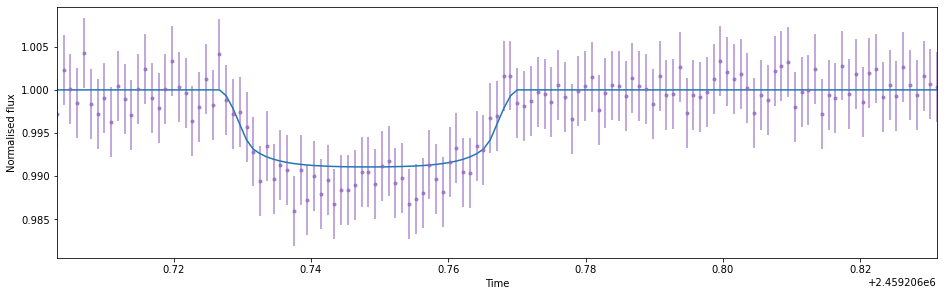

In [11]:
lpf.plot_light_curve();